In [6]:
%pylab inline
import sys
sys.path.append("/gymreklab-tscc/bonnieh/helper_functions")
from Joint_method_functions import *
import glob
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as ticker
import seaborn as sns
from statistics import mode
from scipy import stats

PLOTDIR = '/storage/BonnieH/selection_project/figures/figures/figure2/'

Populating the interactive namespace from numpy and matplotlib


/storage/BonnieH/anaconda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
# Given file, get ABC lookup table
def getABCTable(file):
    num_bins = 0
    
    # Return list of lists that contain [s, het, common]
    table = GetABCList(file, num_bins)
    dic_summ_stats = {}
        
    # Fill in dic_summ_stats: Key is s, value is list of het, number of common alleles pairs for given s value
    for combo in table:
        s_round = get_LRT_bin(combo[0])
        if s_round not in dic_summ_stats:
            dic_summ_stats[s_round] = []
        dic_summ_stats[s_round].append([combo[1], combo[2]]) # Append het, number of common alleles for s value
    
    return dic_summ_stats

In [8]:
def GetObsHetDistrFn(motif_to_use, opt):
    inFile = '/gymreklab-tscc/bonnieh/input_files/' + '1kg_allele_freqs.txt'
    
    allele_freqs_file = open(inFile, 'r')
    
    obs_het_distr_all = []
    obs_common_distr_all = []
    opt_allele_list = []
    count = 0
   
    # Get STRs (represented by optimal allele list) to estimate s jointly on
    # Get observed het and common alleles distribution on these STRs
    for line in allele_freqs_file:
        
        # Get information from line
        info = line.strip().split('\t')
        chrom = info[0]
        start = int(info[1])
        end = int(info[2])
        freqs = info[3]
        per = int(info[5])
        motif = info[6]
        
        canonical_motif = GetCanonicalRU(motif)
        
        opt_allele, allele_freqs = Process_Freqs(freqs, per, end, start, True, True)
        
        
        if canonical_motif == motif_to_use and per == len(motif_to_use) and (opt == 0 or opt == opt_allele):
            count = count + 1
            obs_het = 1-sum([item**2 for item in allele_freqs])
            obs_common = len([i for i in allele_freqs if i >= 0.05])
            obs_het_distr_all.append(obs_het)
            obs_common_distr_all.append(obs_common)
            opt_allele_list.append((per, opt_allele))
                   
    allele_freqs_file.close()
   
    opt_allele_sub_list = []
    obs_het_distr = []
    obs_common_distr = []
    total_number_loci = len(opt_allele_list)
    
    if len(opt_allele_list) <= 1000:
        opt_allele_sub_list = opt_allele_list
        obs_het_distr = obs_het_distr_all
        obs_common_distr = obs_common_distr_all
      
    # Get random heterozygosity and number of common alleles distributions
    else:
        
        divisor = int(len(opt_allele_list)/1000) + 2
        num_loci_added = 0
        while num_loci_added < 1000:
            divisor = divisor * num_loci_added + 5
            if divisor > len(opt_allele_list):
                divisor = divisor%len(opt_allele_list)
            
            toAdd = opt_allele_list.pop(divisor)
            opt_allele_sub_list.append(toAdd)
            toAddHet = obs_het_distr_all.pop(divisor)
            obs_het_distr.append(toAddHet)
            toAddComm = obs_common_distr_all.pop(divisor)
            obs_common_distr.append(toAddComm)
            num_loci_added = num_loci_added + 1
    
    return obs_het_distr, opt_allele_sub_list

In [9]:
# Different colormap options: 'binary', 'hot_r', 'Blues', 'YlGnBu', 'Greens', 'viridis', 'cool'
def main():
    
    pval_threshold = 0.05
    goodness_of_fit_file = open('goodness_of_fit_motif_analysis.txt','w')
    
    print('Running main')
    combos = [(2, 'intergenic'),(3, 'intergenic'),(4, 'intergenic')]#,(2, 'all'),(3, 'all'),(4, 'all')]
    superfolder = 'results_top_x'#_bin_agnostic_upd'#'results_intergenic_ks_test_upd'
    subfolder = 'motif_analysis_diff_mu'
    colormap = 'Blues'#'hot_r'
    folders_dict = {} # Key: Tuple (Period, whether intergenic/all loci), Value: List of folders corresponding to period
    
    folders_dict[(2, 'intergenic')] = ['t1','t2','t3','t4','t5','t6']
    folders_dict[(3, 'intergenic')] = ['t7','t8','t9','t10','t11','t12','t13']
    folders_dict[(4, 'intergenic')] = ['t14','t15','t16','t17','t18','t19','t20']
    
    num_files_dict = {} # Key: Period, Value: Number of files
    num_files_dict[2] = 30
    num_files_dict[3] = 72
    num_files_dict[4] = 36
    
    opt_dic = {}
    opt_dic[2] = ['11','12','13','14','15','16','17','18','19','20']
    opt_dic[3] = ['05','06','07','08','09','10','11','12','13']
    opt_dic[4] = ['07','08','09','10']
    
    
    motif_dic = {}
    motif_dic[2] = ['AT','AG','AC']
    motif_dic[3] = ['AAT','ATC','AAG','AGG','AGC','CCG','AAC','ACC'] 
    motif_dic[4] = ['AAAT','AATC','AATG','ATCC','AAAG','AAGG','AGAT','AAAC','ACAT']
    
    file_name_dic = {}
    file_name_dic[2] = 'dinuc'
    file_name_dic[3] = 'trinuc'
    file_name_dic[4] = 'tetranuc'
    
    for combo in combos:
        
        per = combo[0]
        list_of_percents = []
        list_of_num_loci = []
        list_of_pvalue= []

        # Plot heatmap for each motif in given period
        for i in range(0,1):
            for motif in motif_dic[per]:
                for opt in opt_dic[per]:
                    file_list = glob.glob('/gymreklab-tscc/bonnieh/joint_method/%s/%s/per_%d_*%s*opt_%s.txt'%(superfolder, subfolder, per, motif, opt))
                    
                    if 1>0:
                        filename = file_list[0]
                        results_file = open(filename, 'r')
                        
                        for k in range(0, 2):
                            line= results_file.readline()
                        
                        info = line.strip().split(': ')
                        num_loci = info[1]
                        num_loci = num_loci.strip().split(' ')
                        num_loci = int(num_loci[0])
                        
                        list_of_num_loci.append(num_loci)
                        
                        if num_loci == 0:
                            
                            for elem in mut_setting_dic[per]:
                                list_of_percents.append(0)
                                list_of_pvalue.append(0)
                        
                        else:
                            for k in range(0, 10):
                                line= results_file.readline()
                            info = line.strip().split(',')
                            a_val = float(info[0])
                            b_val = float(info[1])
                            print('a val')
                            print(a_val)
                            print('b val')
                            print(b_val)
                            
                            print((motif,opt))
                            mode_setting = filename.split('_')
                            mode_setting = mode_setting[12]
                            print('mode setting')
                            print(mode_setting)
                            
                            
                            # Get observed heterozygosity 
                            if opt[0] == '0':
                                opt_num=int(opt[1]) 
                            else:
                                opt_num=int(opt)
                                
                            goodness_of_fit_file.write(motif + '\t' + str(opt_num) + '\t' + mode_setting + '\n')
                            obs_het_distr, opt_allele_sub_list = GetObsHetDistrFn(motif, opt_num)
                            # Get simulated heterozygosity
                            
                            mut_setting_folder_name = {}
                            mut_setting_folder_name[2] = 'eurodem_prior2_dinuc_'
                            mut_setting_folder_name[3] = 'eurodem_prior2_trinuc_'
                            mut_setting_folder_name[4] = 'eurodem_prior2_tetranuc_'

                            folder_prefix = mut_setting_folder_name[len(motif)]
                            #for mut_setting in mut_settings[len(motif)]:
                            file = '/gymreklab-tscc/bonnieh/abc/results/' + folder_prefix + mode_setting + '/' + str(len(motif)) + '_' + str(opt_num) + '.txt'

                            ABC_dic = {}
                            ABC_dic[opt_num] = getABCTable(file)
                            
                            ABC_tables_mut = ABC_dic
                            count = 0
                            for zz in range(0, 100):
                                sim_het_list, sim_common_list = GetLists(ABC_tables_mut, opt_allele_sub_list, a_val, b_val)

                                ks_stat, pval = stats.ks_2samp(obs_het_distr, sim_het_list)
                                if pval > pval_threshold:
                                    count = count + 1
                                #if pval < 0.05:
                                    #list_of_pvalue.append(0)
                                #else:
                                    #list_of_pvalue.append(1)
                            list_of_pvalue.append(count)
                            print(count)
                            
                        results_file.close()
        matrix = np.zeros((len(motif_dic[per]), len(opt_dic[per])))
        #print(matrix)
        counter = 0

        for i in range(len(motif_dic[per])): 
            for j in range(len(opt_dic[per])):
                #print(i,j)
                matrix[i,j] = list_of_pvalue[counter]
                counter = counter + 1

        # Visualize heatmap

        print(matrix)
      
        opt = []
        
        for opt_num in opt_dic[per]:
            if opt_num[0] == '0':
                opt.append(opt_num[1]) 
            else:
                opt.append(opt_num)

        print(matrix)
        fig, ax = plt.subplots()
        
        im = ax.imshow(matrix,cmap=colormap) 
        cbar = fig.colorbar(im)
        cbar.ax.set_ylabel('Percent simulations with good fit')

        # Show all ticks
        ax.set_xticks(np.arange(len(opt)))
        ax.set_yticks(np.arange(len(motif_dic[per])))

        # Label ticks
        ax.set_xticklabels(opt)
        ax.set_yticklabels(motif_dic[per])

        if per == 2:
            ax.set_title('Dinucleotides',fontsize=20)
        if per == 3:
            ax.set_title('Trinucleotides',fontsize=20)
        if per == 4:
            ax.set_title('Tetranucleotides',fontsize=20)
        
        #plt.savefig(PLOTDIR + 'heatmap_%d_%s_w_cbar.pdf'%(per, combo[1]),bbox_inches='tight')
        plt.yticks(size=15)
        plt.xticks(size=15)
        fig.tight_layout()
    goodness_of_fit_file.close()

Running main
a val
0.44752875305813267
b val
8.09033449058153e-05
('AT', '11')
mode setting
d
90
a val
0.508784334112344
b val
3.510971341736789e-05
('AT', '12')
mode setting
d
32
a val
0.6587633572639632
b val
7.629017794842125e-05
('AT', '13')
mode setting
d
4
a val
0.9794305721518444
b val
7.740495113384183e-05
('AT', '14')
mode setting
d
0
a val
0.17276953361973124
b val
0.00011967399134640509
('AT', '15')
mode setting
d
4
a val
0.9230991675102319
b val
7.852682578188258e-05
('AT', '16')
mode setting
d
29
a val
0.38623287043800947
b val
9.823187502873324e-05
('AT', '17')
mode setting
d
54
a val
0.904201779836025
b val
1.986384491895268e-05
('AT', '18')
mode setting
d
94
a val
0.6839377100540067
b val
4.8682932336235565e-05
('AT', '19')
mode setting
d
73
a val
0.09747852513826394
b val
0.0008459145891372677
('AT', '20')
mode setting
d
100
a val
0.6650590018268594
b val
0.0009088504465352705
('AG', '11')
mode setting
e
0
a val
0.19897250765222219
b val
0.003219652349961097
('AG', '12

100
a val
0.969445188996536
b val
0.001313028704940151
('ACC', '05')
mode setting
e
0
a val
0.2623126745107598
b val
0.000341287743797834
('ACC', '06')
mode setting
e
0
a val
0.33241863048008546
b val
0.0008569728046275508
('ACC', '07')
mode setting
e
0
a val
0.32742130255383894
b val
0.000849510647096329
('ACC', '08')
mode setting
e
17
a val
0.9736264285141146
b val
6.01284006919679e-05
('ACC', '09')
mode setting
e
93
a val
0.03141601262236127
b val
0.0013143596660907687
('ACC', '10')
mode setting
e
100
a val
0.623289546035217
b val
5.83622610961825e-05
('ACC', '11')
mode setting
e
100
a val
0.20313410462872183
b val
0.0008309518241539444
('ACC', '12')
mode setting
e
100
a val
0.5060672051667628
b val
0.0002487607757598108
('ACC', '13')
mode setting
e
100
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 100. 100.  99. 100.  48. 100.]
 [  0.   0.   0.  33.  77.  81. 100.  70. 100.]
 [  0.   0.   0.  98.  97.  98.  99.  96.  85.]
 [  0.   0.   0.  45.  97.  98.  98. 100.

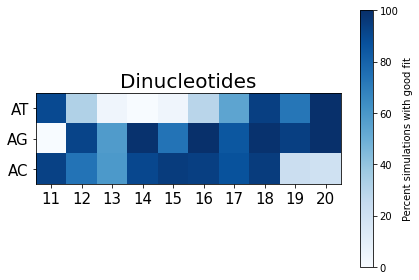

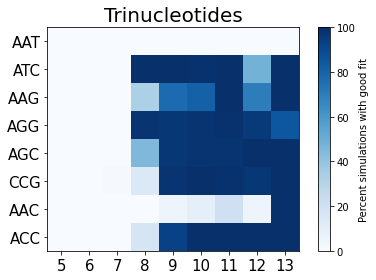

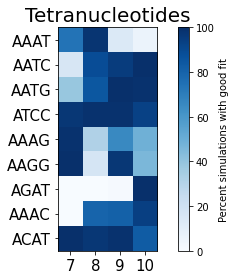

In [10]:
%%time
if __name__ == '__main__':
    main()